<h1 align="center" style="color: green;">The Fourier Transform</h1>
<p align="center" style="font-weight: bold">by Eric Riddoch</p>
<p style="font-weight: bold" align="center">Nov 30, 2018</p>
    
<h3 style="color: green;" align="center">Contents</h3>

<p>This notebook showcases the advanced mathematics used to build up the Discrete Fourier Transform algorithm. Below, I compare the Fast Fourier Transform to the Naive Approach and then use it to decompose and clean audio signals. At the end, I use the two dimensional version to demonstrate an image cleaning technique.</p>

<h5 style="color: green">Part 1: The Discrete Fourier Transform</h5>
<ol>
    <li>SoundWave Class</li>
    <li>Note Generator</li>
    <li>Special Operators</li>
    <li>Naive Fourier Transform</li>
    <li>Fast Fourier Transform</li>
    <li>Plots</li>
</ol>
<h5 style="color: green">Part 2: Convolution and Filtering</h5>
<ol>
    <li>Circular Convolution</li>
    <li>Linear Convolution</li>
    <li>Cleaning Audio</li>
    <li>Cleaning Images</li>
</ol>

<h2 align="center" style="color: green;">Part 1: The Discrete Fourier Transform</h2>



In [1]:
from matplotlib import pyplot as plt
import IPython
from scipy.io import wavfile
import numpy as np
from colorama import Fore
from scipy.fftpack import fft, ifft, fft2, ifft2
from scipy.signal import fftconvolve
import imageio
import math
from timeit import default_timer as time

In [2]:
plt.rcParams["figure.dpi"] = 300             # Fix plot quality.
plt.rcParams["figure.figsize"] = (12,3)      # Change plot size / aspect (you may adjust this).

<h1 style="color: green">1.1 SoundWave Class</h1>

Throughout this demonstration, we interact with <code>.wav</code> files using the following class.

Definitions, 
<li><code>SoundWave.samples</code> - For any soundwave $f(t)$, we record the sound by sampling from $f$ at equally spaced times, $t_0 < t_1 < ... < t_{n-1}$ to obtain the vector $\textbf{f} = (f(t_0), f(t_1), ..., f(t_{n-1}))$. We store this vector in <code>SoundWave.samples</code>.
<li><code>SoundWave.rate</code> - refers to the <strong>sample rate</strong> of an audio clip, which is the constant distance $t_k - t_{k-1}$ for any $1 \le k \le n - 1$.</li>

In [3]:
class SoundWave(object):
    """A class for working with digital audio signals."""

    SAMPLE_MAX = 32767
    SAMPLE_MIN = -32768
    
    # constant notes 
    notes = {
        'A' : 440,
        'B' : 493.88,
        'C' : 523.25,
        'D' : 587.33,
        'E' : 659.25, 
        'F' : 698.46, 
        'G' : 783.99, 
        'A_high' : 880
    }
    
    def __init__(self, rate, samples):
        """Set the SoundWave class attributes.

        Parameters:
            rate (int): The sample rate of the sound.
            samples ((n,) ndarray): NumPy array of samples.
        """
        self.rate = rate
        self.samples = samples
        self.filename = None
        
    def calculate_hertz(self):
        # return essential information from fft
        n = len(self.samples)
        c_k = abs(fft(self.samples))
        k_indices = np.arange(n)
        frequencies = k_indices * self.rate / n
        return c_k, k_indices, frequencies

    def plot(self, title="", x_min=None, x_max=None, 
             y_min=None, y_max=None, 
             dft=False):
        """Plot the graph of the sound wave (time versus amplitude)."""
        domain = np.linspace(0, len(self.samples) / self.rate, 
                             len(self.samples))
        
        if y_min is None and y_max is None:
            y_min = self.SAMPLE_MIN
            y_max = self.SAMPLE_MAX
        
        # case : two subplots
        if dft:
            fig, axes = plt.subplots(1, 2)
            n = len(self.samples)
            
            # plot soundwave against time
            axes[0].plot(domain, self.samples)
            axes[0].set_ylim(y_min, y_max)
            axes[0].set_ylabel("samples")
            axes[0].set_xlabel("seconds")
            axes[0].set_title("Sound Wave")
            
            # calculate hertz
            c_k, k_indices, frequencies = self.calculate_hertz()
            
            # plot magnitude against frequency
            axes[1].plot(frequencies[:n//2], c_k[:n//2])
            axes[1].set_ylabel("amplitude")
            axes[1].set_xlabel("frequency (Hz)")
            axes[1].set_title("Component Frequencies")
            
            if x_min is not None and x_max is not None:
                axes[1].set_xlim(x_min, x_max)
            
            fig.suptitle(f"Fourier Transform - {title}")
                        
        # case : one subplot
        else:
            plt.plot(domain, self.samples)
            plt.ylim(self.SAMPLE_MIN, self.SAMPLE_MAX)
            plt.ylabel("samples")
            plt.xlabel("seconds")
            plt.title(title)
            
        plt.show()

    def export(self, filename, force=False):
        """Generate a wav file from the sample rate and samples. 
        If the array of samples is not of type np.int16, scale it before exporting.

        Parameters:
            filename (str): The name of the wav file to export the sound to.
        """
        samples = None
            
        # rescale?
        if self.samples.dtype != np.int16 or force:
            scaled_samples = np.int16( (self.samples * float(self.SAMPLE_MAX))
                                   / max(abs(self.samples)) )
            samples = scaled_samples
        else:
            samples = self.samples
                                      
        wavfile.write(filename, self.rate, samples)
        
    def get_note(self, sound, tol=5):
        """Given a frequency, identify the note it corresponds with."""
        
        # find the note
        for note in self.notes.keys():
            if abs(sound - self.notes[note]) < tol:
                return note
        
    def __add__(self, other):
        """Combine the samples from two SoundWave objects.

        Parameters:
            other (SoundWave): An object containing the samples to add
                to the samples contained in this object.
        
        Returns:
            (SoundWave): A new SoundWave instance with the combined samples.

        Raises:
            ValueError: if the two sample arrays are not the same length.
        """
        
        # componentwise add two sounds
        if len(self.samples) != len(other.samples):
            raise ValueError("DUMB!")
        
        return SoundWave(self.rate, self.samples + other.samples)

    def __rshift__(self, other):
        """Concatentate the samples from two SoundWave objects.

        Parameters:
            other (SoundWave): An object containing the samples to concatenate
                to the samples contained in this object.

        Raises:
            ValueError: if the two sample rates are not equal.
        """
        
        # concatenate two sound waves
        if self.rate != other.rate:
            raise ValueError("DUMB!")
            
        return SoundWave(self.rate, np.hstack([self.samples, other.samples]))
    
    def __mul__(self, other):
        """Convolve the samples from two SoundWave objects using circular convolution.
        
        Parameters:
            other (SoundWave): An object containing the samples to convolve
                with the samples contained in this object.
        
        Returns:
            (SoundWave): A new SoundWave instance with the convolved samples.

        Raises:
            ValueError: if the two sample rates are not equal.
        """
        if self.rate != other.rate:
            raise ValueError("Rates not equal")
        else:
            if len(self.samples) < len(other.samples):
                self.samples = np.pad(self.samples,(0,len(other.samples) - len(self.samples)),'constant')
            elif len(self.samples) > len(other.samples):
                other.samples = np.pad(other.samples,(0,len(self.samples) - len(other.samples)),'constant')
            #convolve arrays
            convolution = ifft(fft(self.samples) * fft(other.samples))
            return SoundWave(self.rate, convolution)

    def __pow__(self, other):
        """Convolve the samples from two SoundWave objects using linear convolution.
        
        Parameters:
            other (SoundWave): An object containing the samples to convolve
                with the samples contained in this object.
        
        Returns:
            (SoundWave): A new SoundWave instance with the convolved samples.

        Raises:
            ValueError: if the two sample rates are not equal.
        """
        if self.rate != other.rate:
            raise ValueError("Rates not equal")
        else:
            n = len(self.samples)
            m = len(other.samples)
            length = n + m - 1
            a = np.log2(length)
            a = math.ceil(a)
            
            self_sam = np.pad(self.samples,(0,2**a - n),'constant')
            other_sam = np.pad(other.samples,(0,2**a - m),'constant')
            
            #convolve arrays
            convolution = ifft(fft(self_sam) * fft(other_sam))
            
            #take first n+m-1 elements
            convolution = convolution[:length]
            
            return SoundWave(self.rate, convolution)    

    def clean(self, low_freq, high_freq):
        """Remove a range of frequencies from the samples using the DFT. 

        Parameters:
            low_freq (float): Lower bound of the frequency range to zero out.
            high_freq (float): Higher boound of the frequency range to zero out.
        """
        
        # take DFT of the sound
        c_k = fft(self.samples)
        n = len(self.samples)
         
        # compute k values to erase
        k_low = int( low_freq * n / self.rate )
        k_high = int( high_freq * n / self.rate )

        # delete the frequencies
        c_k[k_low:k_high] = 0
        c_k[n - k_high : n - k_low] = 0
        
        # invert DFT back into sound file
        c_k = ifft(c_k)
        
        # save the new sound
        self.samples = c_k
        
    def set_file(self, filename):
        """update file associated with SoundWave instance"""
        self.filename = filename
    
    def play(self, filename=None, stereo=False):
        """embed an audio player into the notebook"""
        if stereo:
            return IPython.display.Audio(rate=self.rate, data=self.samples.T)
        if filename is None:
            return IPython.display.Audio(rate=self.rate, data=self.samples)
        else:
            return IPython.display.Audio(filename)
        
    @staticmethod
    def play_file(filename):
        return IPython.display.Audio(filename)
        
    @classmethod
    def with_file(cls, filename):
        """instantiate a SoundWave object associated with a particular .wav file"""
        rate, samples = wavfile.read(filename)
        obj = cls(rate, samples)
        obj.set_file(filename)
        return obj

<h1 style="color: green">1.2 Note Generator</h1>

<code>generate_note()</code> generates samples from a soundwave with a specified freqency for a specified amount of time.


In [4]:
def generate_note(frequency, duration):
    """Generate an instance of the SoundWave class corresponding to 
    the desired soundwave. Uses sample rate of 44100 Hz.
    
    Parameters:
        frequency (float): The frequency of the desired sound.
        duration (float): The length of the desired sound in seconds.
    
    Returns:
        sound (SoundWave): An instance of the SoundWave class.
    """
    
    # create a SoundWave with the given frequency
    RATE = 44100
    num_samples = duration * RATE
    domain = np.linspace(0, num_samples / RATE, num_samples)
    samples = np.sin(2*np.pi * domain * frequency)
    
    return SoundWave(RATE, samples)

# 2 second A note
generate_note(SoundWave.notes['A'], 2).play()

<h1 style="color: green">1.3 Special Operators</h1>

<p>Note that in the <code>SoundWave</code> class we define the operators <code>+</code> and <code>>></code>.</p>

<li><code>+</code> combines two <code>SoundWave</code> objects of the same <code>rate</code> by adding their sample arrays componentwise.</li>
<li><code>>></code> appends one the sample vector of one <code>SoundWave</code> object to another provided they share the same rate.</li>


<p>Below, I demonstrate this by generating a three-second A minor chord (A, C, and E), and play a 'Super Mario' jingle. :D<p>

In [5]:
C_Note = generate_note(SoundWave.notes['C'], 3)
E_Note = generate_note(SoundWave.notes['E'], 3)
A_Note = generate_note(SoundWave.notes['A'], 3)
C_Up = generate_note(SoundWave.notes['C'] + 440, 3)
G = 783.99

# Play A, C, and E together, the arpegio is below
(C_Note + E_Note + A_Note).play()


In [6]:
# Mario :D

E = SoundWave.notes['E']
C = SoundWave.notes['C']
G = SoundWave.notes['G']

(
    generate_note(E, .15) >> generate_note(0, .1) >>
    generate_note(E, .15) >> generate_note(0, .2) >>
    generate_note(E, .15) >> generate_note(0, .2) >>
    generate_note(C, .15) >> generate_note(0, .2) >>
    generate_note(E, .15) >> generate_note(0, .2) >>
    generate_note(G, .5) >> generate_note(0, .5)
).play()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  app.launch_new_instance()


We generate the 'arpegio' $A \rightarrow C \rightarrow E$ where each note lasts for one second.

In [7]:
# do what the above says
ACE = (generate_note(SoundWave.notes['A'], 1) 
       >> generate_note(SoundWave.notes['C'], 1) 
       >> generate_note(SoundWave.notes['E'], 1))
ACE.play()

<h1 style="color: green">1.4 Naive Fourier Transform</h1>

Recall that $\textbf{f}$ is a sample vector. We denote the Discrete Fourier Transform of $\textbf{f}$ as $\widehat{\textbf{f}} = (c_0, c_1, ..., c_{n-1})$, where each $c_k$ are the <strong>Fourier coefficients</strong> of $f$ with respect to the orthonormal basis {$ e^{-2 \pi i k \ell\, /\, n}$}$_{k \in ℤ}$, so

$$
c_k = \frac{1}{n}\sum_{\ell=0}^{n-1} f_\ell e^{-2 \pi i k \ell\, /\, n}
$$

- `simple_dft()` calculates $c_k$ given by the formula above
- Using `np.allclose()`, we verify that  `simple_dft()` and the industry standard implementation `scipy.fftpack.fft()` give the same result (after scaling).

Note, this sum can be expressed as a matrix-vector multiplication. That is how we compute it in the code below:


In [8]:
def simple_dft(samples):
    """Compute the DFT of an array of samples.

    Parameters:
        samples ((n,) ndarray): an array of samples.
    
    Returns:
        ((n,) ndarray): The DFT of the given array.
    """
    
    
    # calculate the DFT of any vector 
    def DFT(f):
        """
        Compute the discrete Fourier Transform of the 1D array 
        via matrix-vector multiplication"""
        
        n = len(f)
        m = np.arange(n).reshape(n,1)
        W = np.exp((-2j * np.pi/float(n)) * m @ m.T)
        return W @ f / float(n)
    
    return DFT(samples) 

In [9]:
# calculate DFT(A)
A_note = generate_note(SoundWave.notes['A'], .1)

my_dft = simple_dft(A_note.samples)
print("OUR DFT")
print(my_dft)

print("SCIPY DFT")
scipy_dft = fft(A_note.samples)
scale = len(A_note.samples)
scipy_dft /= scale
print(scipy_dft)

print()
print(f"{Fore.BLUE}The answers are close: {Fore.GREEN}{np.allclose(scipy_dft, my_dft)}{Fore.BLACK}")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  app.launch_new_instance()


OUR DFT
[-1.58148781e-17+0.00000000e+00j  3.67116142e-09-5.15337949e-06j
  1.47074375e-08-1.03227508e-05j ...  3.31775586e-08+1.55242715e-05j
  1.47074357e-08+1.03227508e-05j  3.67116093e-09+5.15337950e-06j]
SCIPY DFT
[-2.12824215e-17+0.00000000e+00j  3.67116142e-09-5.15337949e-06j
  1.47074375e-08-1.03227508e-05j ...  3.31775588e-08+1.55242715e-05j
  1.47074375e-08+1.03227508e-05j  3.67116142e-09+5.15337949e-06j]

The answers are close: True


<h1 style="color: green">1.5 Fast Fourier Transform</h1>

Computing a single $c_k$ with the naive method has temporal complexity $O(n)$, so computing these values for all $n$ coefficients makes this approach $O(n^2)$. 

In my applied mathematics coursework, I have completed the proof of the <strong>Fast Fourier Transform</strong> which shows that a recursive approach can bring this algorithm to $O(n logn)$ time.

In [10]:
def simple_fft(samples, threshold=1):
    """Compute the DFT using the FFT algorithm.
    
    Parameters:
        samples ((n,) ndarray): an array of samples.
        threshold (int): when a subarray of samples has fewer
            elements than this integer, use simple_dft() to
            compute the DFT of that subarray.
    
    Returns:
        ((n,) ndarray): The DFT of the given array.
    """

    n = len(samples)
    
    # I'm using <= and not < since the algorithm in the pdf says to do that
    if n <= threshold:
        return simple_dft(samples)
    else:
        samples_even = simple_fft(samples[::2]) # even samples
        samples_odd = simple_fft(samples[1::2]) # odd samples
        w = np.exp((-2j * np.pi / n) * np.arange(n))
        first_sum = samples_even + w[:n//2] * samples_odd
        second_sum = samples_even + w[n//2:] * samples_odd
        return 0.5 * np.concatenate([first_sum, second_sum])
    

<h1 style="color: green">1.6 FFT Benchmark</h1>

<p>We compare the time and accuracy of our functions <code>simple_dft()</code> and <code>simple_fft()</code> with the industry standard <code>scipy.fftpack.fft()</code>.</p>

<h4 style="color: green">1.6.1 Time Comparison</h4>

In [11]:
# calculate FFT(A)
noise = np.random.random(size=(8192))

# time the three algorithms
print(f"{Fore.GREEN}\nOUR DFT{Fore.BLACK}")
%time my_dft = simple_dft(noise)
print(f"{Fore.GREEN}\nOUR FFT{Fore.BLACK}")
%time my_fft = simple_fft(noise)
print(f"{Fore.GREEN}\nSCIPY FFT{Fore.BLACK}")
%time scipy_fft = fft(noise)


OUR DFT
CPU times: user 4.29 s, sys: 1.01 s, total: 5.3 s
Wall time: 3.62 s

OUR FFT
CPU times: user 478 ms, sys: 31.3 ms, total: 509 ms
Wall time: 255 ms

SCIPY FFT
CPU times: user 358 µs, sys: 49 µs, total: 407 µs
Wall time: 375 µs


<h4 style="color: green">1.6.2 Accuracy</h4>

In [12]:
# print the accuracy
print(f"{Fore.GREEN}\nOUR DFT{Fore.BLACK}")
print(my_dft)

print(f"{Fore.GREEN}\nOUR FFT{Fore.BLACK}")
print(my_fft)

print(f"{Fore.GREEN}\nSCIPY FFT{Fore.BLACK}")
scale = len(noise)
scipy_fft /= scale
print(scipy_fft)

print()
print(f"{Fore.BLUE}simple_dft matches scipy_fft: {Fore.GREEN}{np.allclose(scipy_fft, my_dft)}{Fore.BLACK}")
print(f"{Fore.BLUE}simple_fft matches scipy_fft: {Fore.GREEN}{np.allclose(scipy_fft, my_fft)}{Fore.BLACK}")


OUR DFT
[ 5.06484932e-01+0.j          1.34908506e-03-0.00176917j
 -3.06220696e-04-0.0035351j  ... -3.19562795e-03-0.00020308j
 -3.06220696e-04+0.0035351j   1.34908506e-03+0.00176917j]

OUR FFT
[ 5.06484932e-01+0.j          1.34908506e-03-0.00176917j
 -3.06220696e-04-0.0035351j  ... -3.19562795e-03-0.00020308j
 -3.06220696e-04+0.0035351j   1.34908506e-03+0.00176917j]

SCIPY FFT
[ 5.06484932e-01+0.j          1.34908506e-03-0.00176917j
 -3.06220696e-04-0.0035351j  ... -3.19562795e-03-0.00020308j
 -3.06220696e-04+0.0035351j   1.34908506e-03+0.00176917j]

simple_dft matches scipy_fft: True
simple_fft matches scipy_fft: True


<h1 style="color: green">1.7 Plots</h1>

We plot the transformation from the time domain to the frequency domain.

- Plot 1: DFT of an A tone
- Plot 2: DFT of an A minor chord

Finally, we decompose `mystery_chord.wav` and identify its component frequencies.

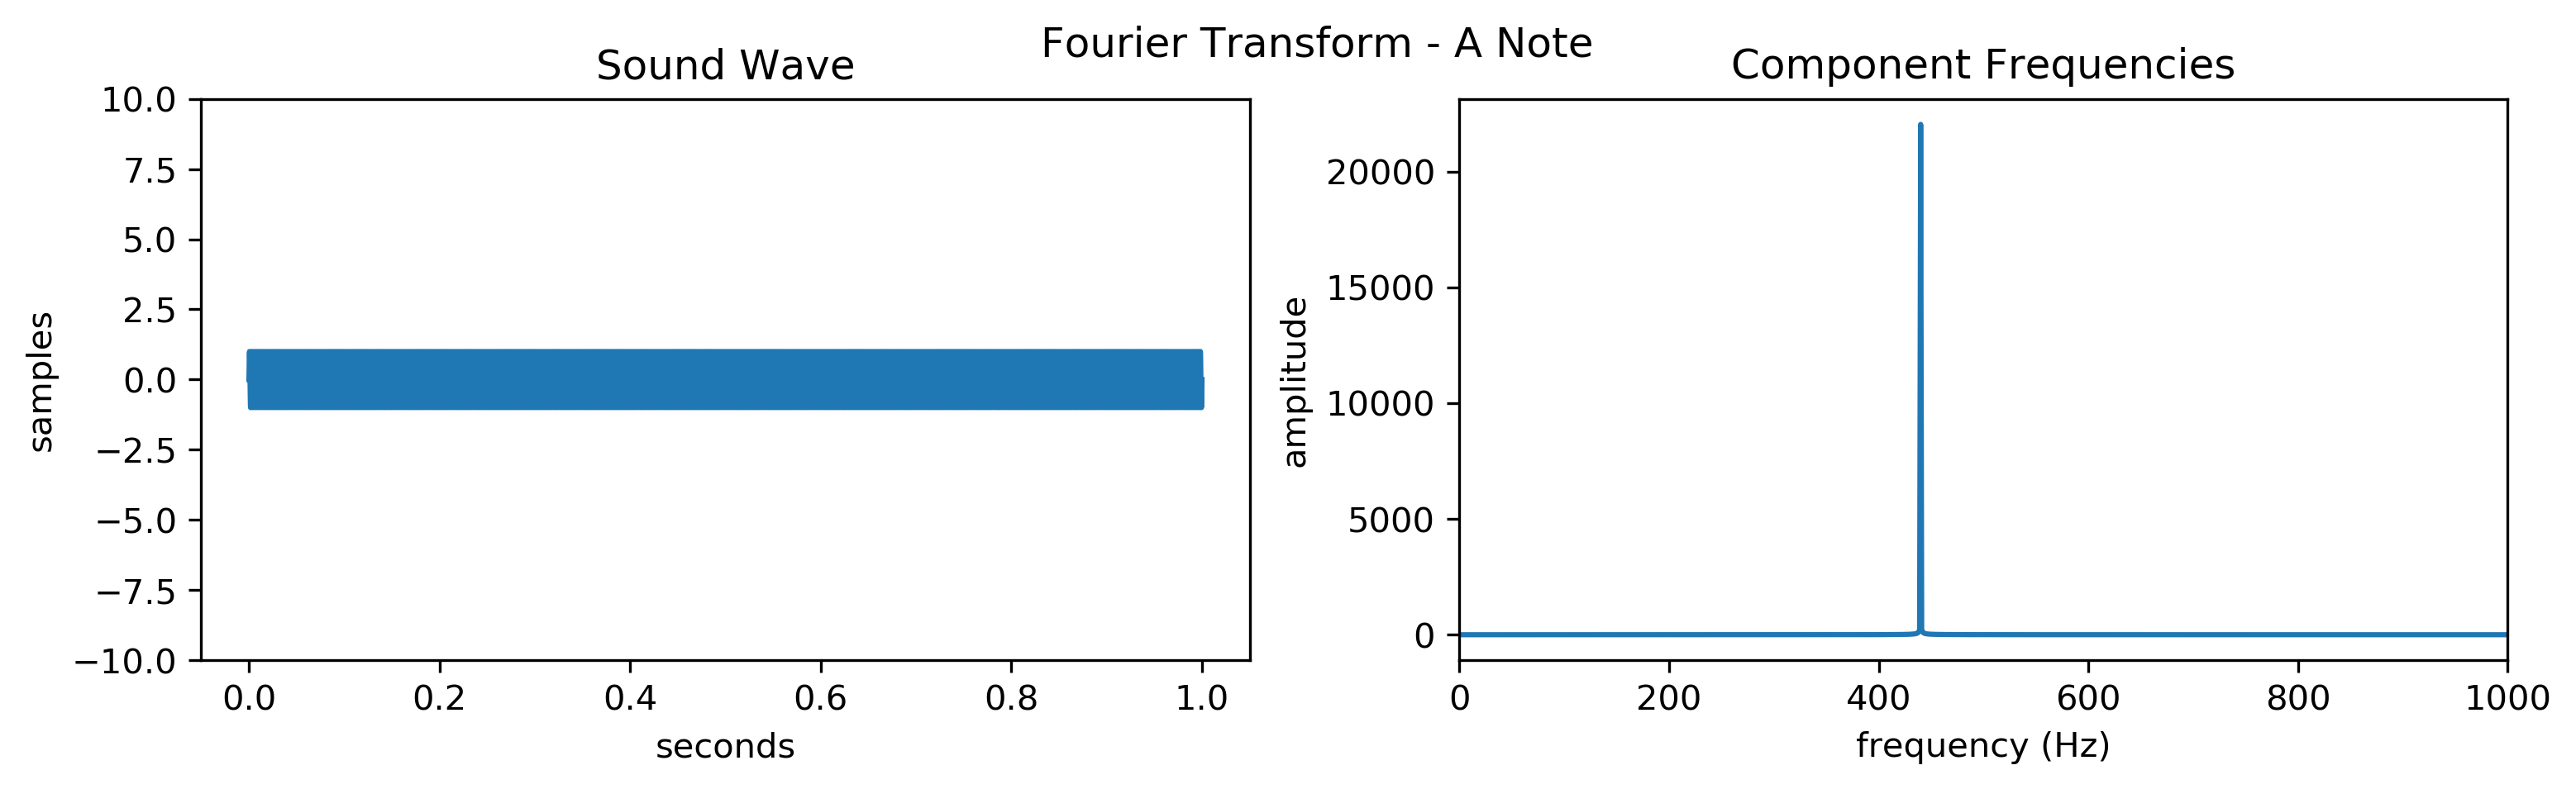

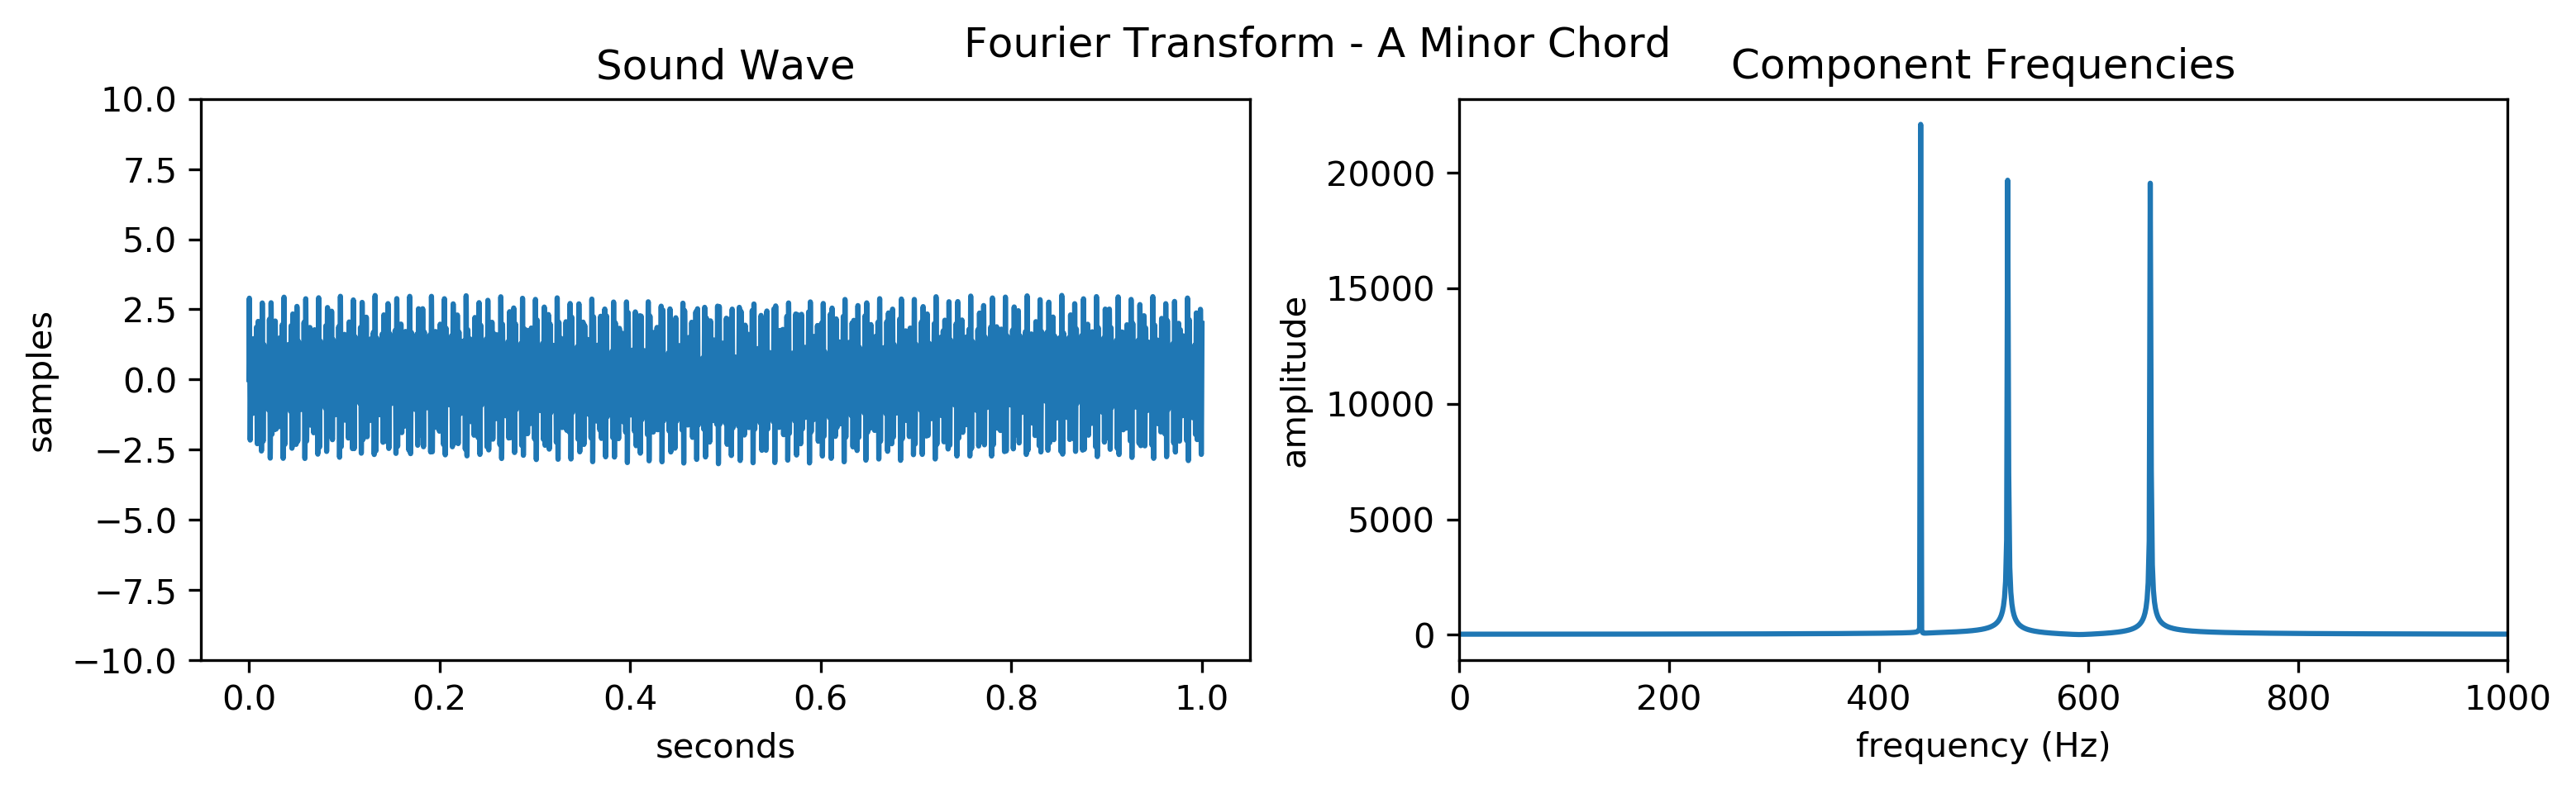

In [13]:
# Plot A minor chord
A_minor = (generate_note(SoundWave.notes['C'], 1) + 
                    generate_note(SoundWave.notes['E'], 1) + 
                    generate_note(SoundWave.notes['A'], 1) )

# Plot A note
A_note = generate_note(440, 1)
A_note.plot("A Note", x_min=0, x_max=1000, y_min=-10, y_max=10, dft=True)

A_minor.play()
A_minor.plot("A Minor Chord", x_min=0, x_max=1000, y_min=-10, y_max=10, dft=True)

Using the DFT to determine the individual notes that are present in `mystery_chord.wav`.

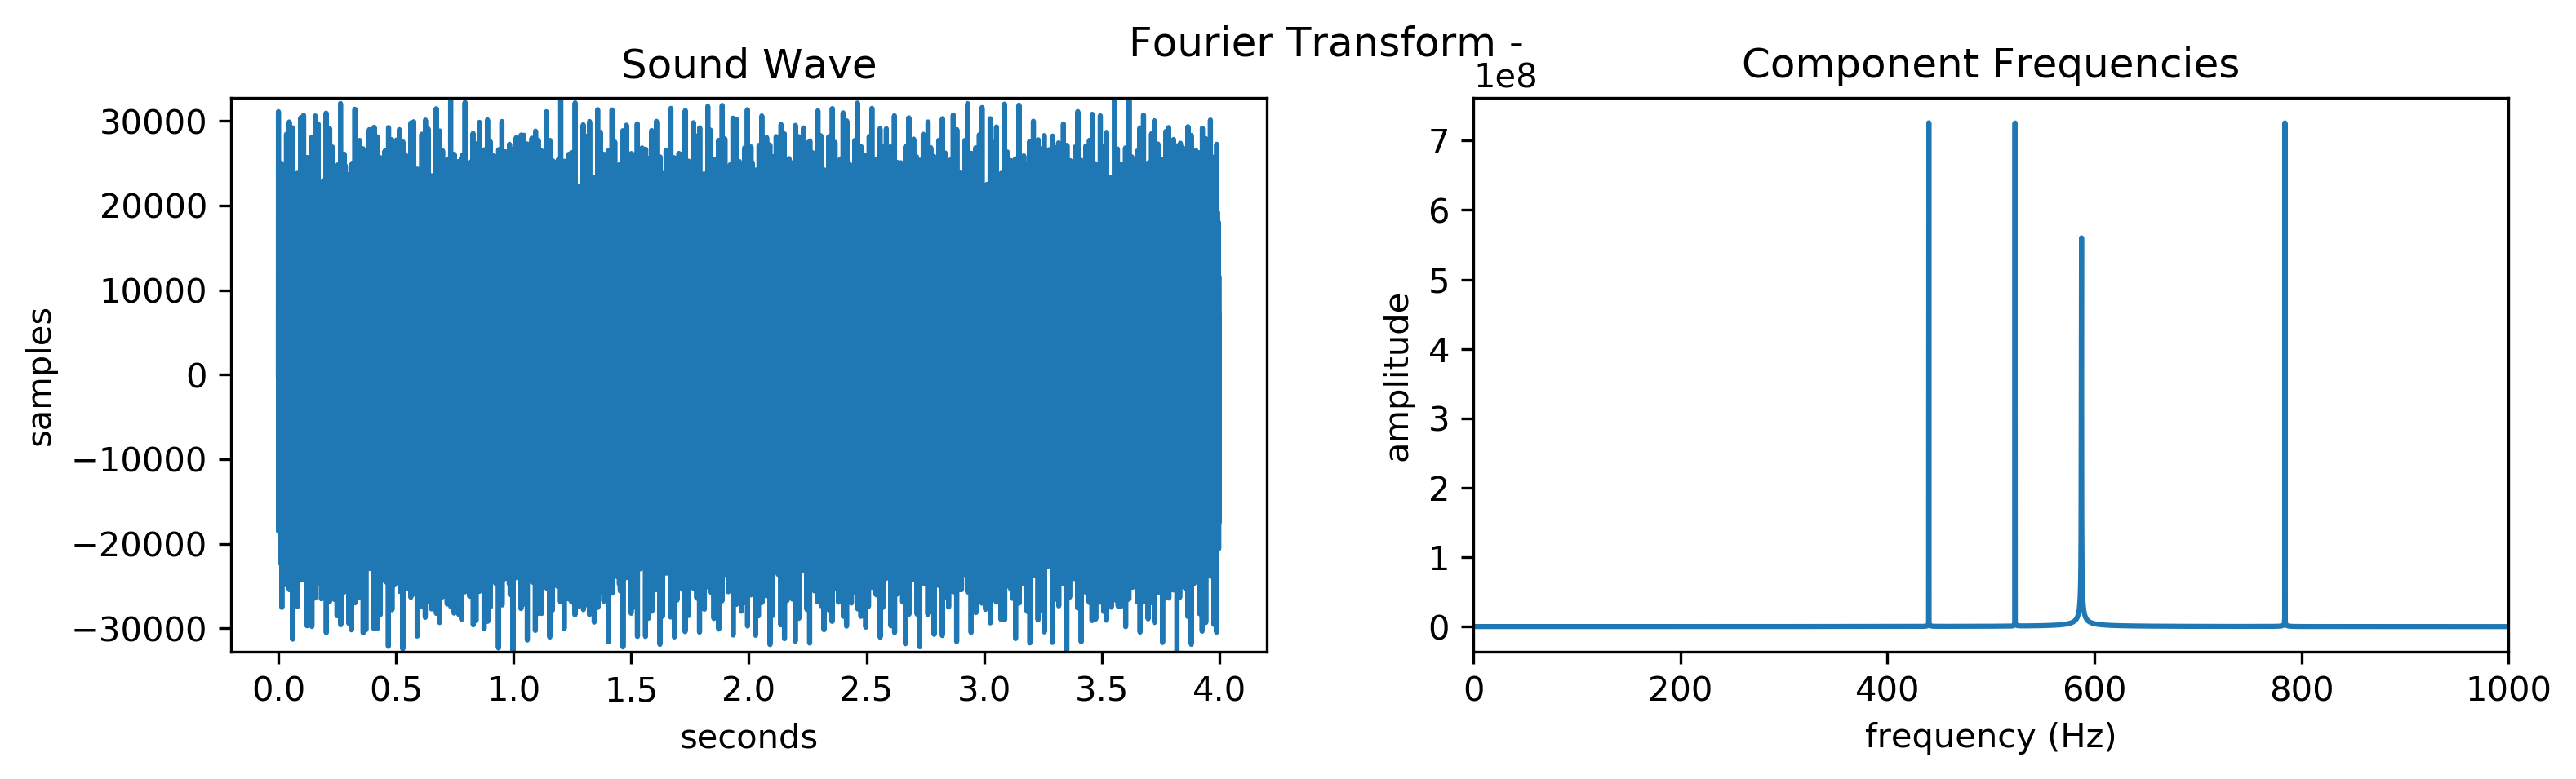

The notes are as follows:
Note:  A 	Frequency:  440.0
Note:  G 	Frequency:  784.0
Note:  C 	Frequency:  523.25
Note:  D 	Frequency:  587.5

My recreation of the chord:


In [14]:
mystery_chord = SoundWave.with_file("mystery_chord.wav")

mystery_chord.plot(x_min=0, x_max=1000, dft=True)

c_k, k_indicies, frequencies = mystery_chord.calculate_hertz()
n = len(c_k)
sort = np.argsort(c_k[:n//2])[::-1]

print(f"{Fore.GREEN}The notes are as follows:{Fore.BLUE}")
for i in range(4):
    print("Note: ", mystery_chord.get_note(frequencies[sort[i]]), "\tFrequency: ", frequencies[sort[i]])
print(f"{Fore.BLACK}")

print("My recreation of the chord:")
my_chord = (
    generate_note(SoundWave.notes['A'], 4)
    + generate_note(SoundWave.notes['G'], 4)
    + generate_note(SoundWave.notes['C'], 4)
    + generate_note(SoundWave.notes['D'], 4)
)
my_chord.play()

<h1 align="center" style="color: green;">Part 2: Convolution and Filtering</h1>

<p><strong>Convolution:</strong> In the sections below I demonstrate my implementation of the <strong><em>Linear</em> and <em>Circular Convolution</em></strong> which are two mathematical methods of combining sample vectors.</p>

<p><strong>Filtering:</strong> Then, I return to the Fourier Transform to clean up sound sound clips and an image.</p>

<h1 style="color: green;">2.1: Circular Convolution</h1>
<p>The <code>*</code> operator performs circular convolution on two <code>SoundWave</code> objects.</p>
<p>Below, I demonstrate this effect by convolving <code>tada.wav</code> with some randomly generated noise.</p>

In [15]:
# # Generate a test sound to convolve
# A = generate_note(SoundWave.notes['A'], 4)
# F = generate_note(SoundWave.notes['F'], 4)
# (A * F)

# convolve tada.wav with white noise
tada = SoundWave.with_file("tada.wav")
rate = 22050        # Create 2 seconds of white noise at a given rate.
white_noise = np.random.randint(-32767, 32767, rate*2, dtype=np.int16)
white_noise = SoundWave(rate, white_noise)

convo = (tada * white_noise)

print(f"{Fore.GREEN}tada.wav")
(convo >> convo).play()

tada.wav


/anaconda3/lib/python3.6/site-packages/IPython/lib/display.py:124: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


In [16]:
# convolution appended with itself
print(f"{Fore.GREEN}tada.wav convolved with white noise")
((tada * white_noise) >> (tada * white_noise)).play()

tada.wav convolved with white noise


/anaconda3/lib/python3.6/site-packages/IPython/lib/display.py:124: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


<h1 style="color: green;">2.2: Linear Convolution</h1>
<p>The <code>**</code> operator performs linear convolution on two <code>SoundWave</code> objects.</p>
<p>Below, I demonstrate this effect by convolving
<ol>
<li> two note complementary note sequences which results in a pulsing effect</li>
<li> a piano sound with a balloon popping in an echoey room. This makes the piano sound like it is in an echoey room, too!</li>
</ol>
</p>

<h4 style="color: green">2.2.1 Note Sequences</h4>

In [17]:
# CGC.wav sound
cgc.play()

NameError: name 'cgc' is not defined

In [ ]:
# GCG.wav sound
gcg.play()

In [ ]:
# linear convolution of the two
(cgc**gcg).play()

<h4 style="color: green">2.2.2 Piano and Balloon</h4>

In [ ]:
# read chopin.wav and balloon.wav
chopin = SoundWave.with_file("chopin.wav")
balloon = SoundWave.with_file("balloon.wav")
convo = fftconvolve(balloon.samples, chopin.samples)
convo = SoundWave(chopin.rate, convo)

In [ ]:
# chopin sound
chopin.play()

In [ ]:
# balloon sound
balloon.play()

In [ ]:
# convolution of chopin and balloon
convo.play()

<h1 style="color: green;">2.3: Cleaning Audio</h1>

<p><code>noisy.wav</code> and <code>noisy2.wav</code> are impossible to make out. <code>vuvuzela.wav</code> has an annoying buzzing-horn sound in the background.</p> 
  
<ol>
<li> To clean <code>noisy.wav</code>, I remove all frequencies in the range $1250$-$2600 $ (Hz).</li>
<li> To clean <code>noisy2.wav</code>, I identified a wider range of frequencies and deleted them.</li>
<li> <code>vuvuzela.wav</code>: I isolated the annoying vuvuzela horn sound, and deleted it.</li>
</ol> 
 
<p>I embedded all the clips from before and after.</p>
<p><strong>Do you recognize them? </strong><code>;)</code></p>
    




<h4 style="color: green">2.3.1 <code>noisy.wav</code> RAW</h4>

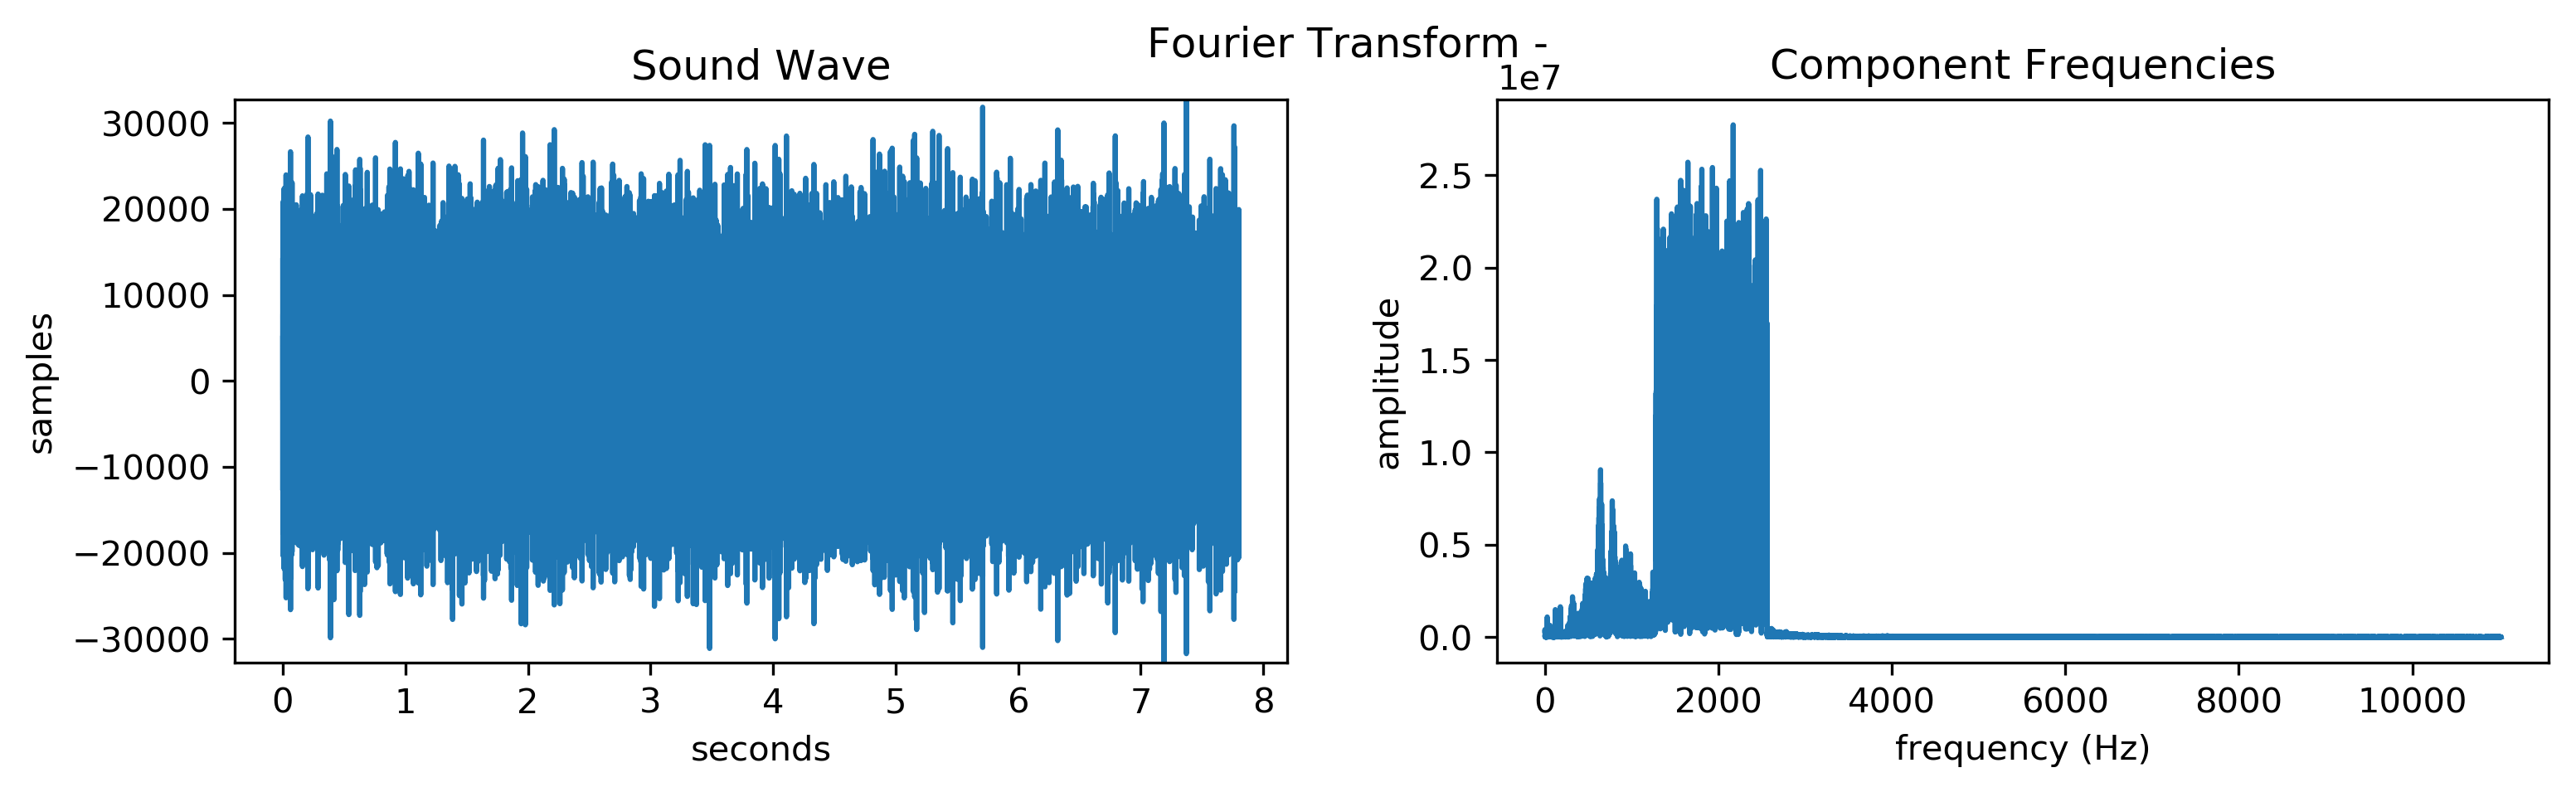

In [18]:
# get and plot noisy.wav
noisy = SoundWave.with_file("noisy1.wav")
noisy.plot(dft=True)
noisy.play()

<h4 style="color: green">2.3.2 <code>noisy.wav</code> CLEAN</h4>

/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


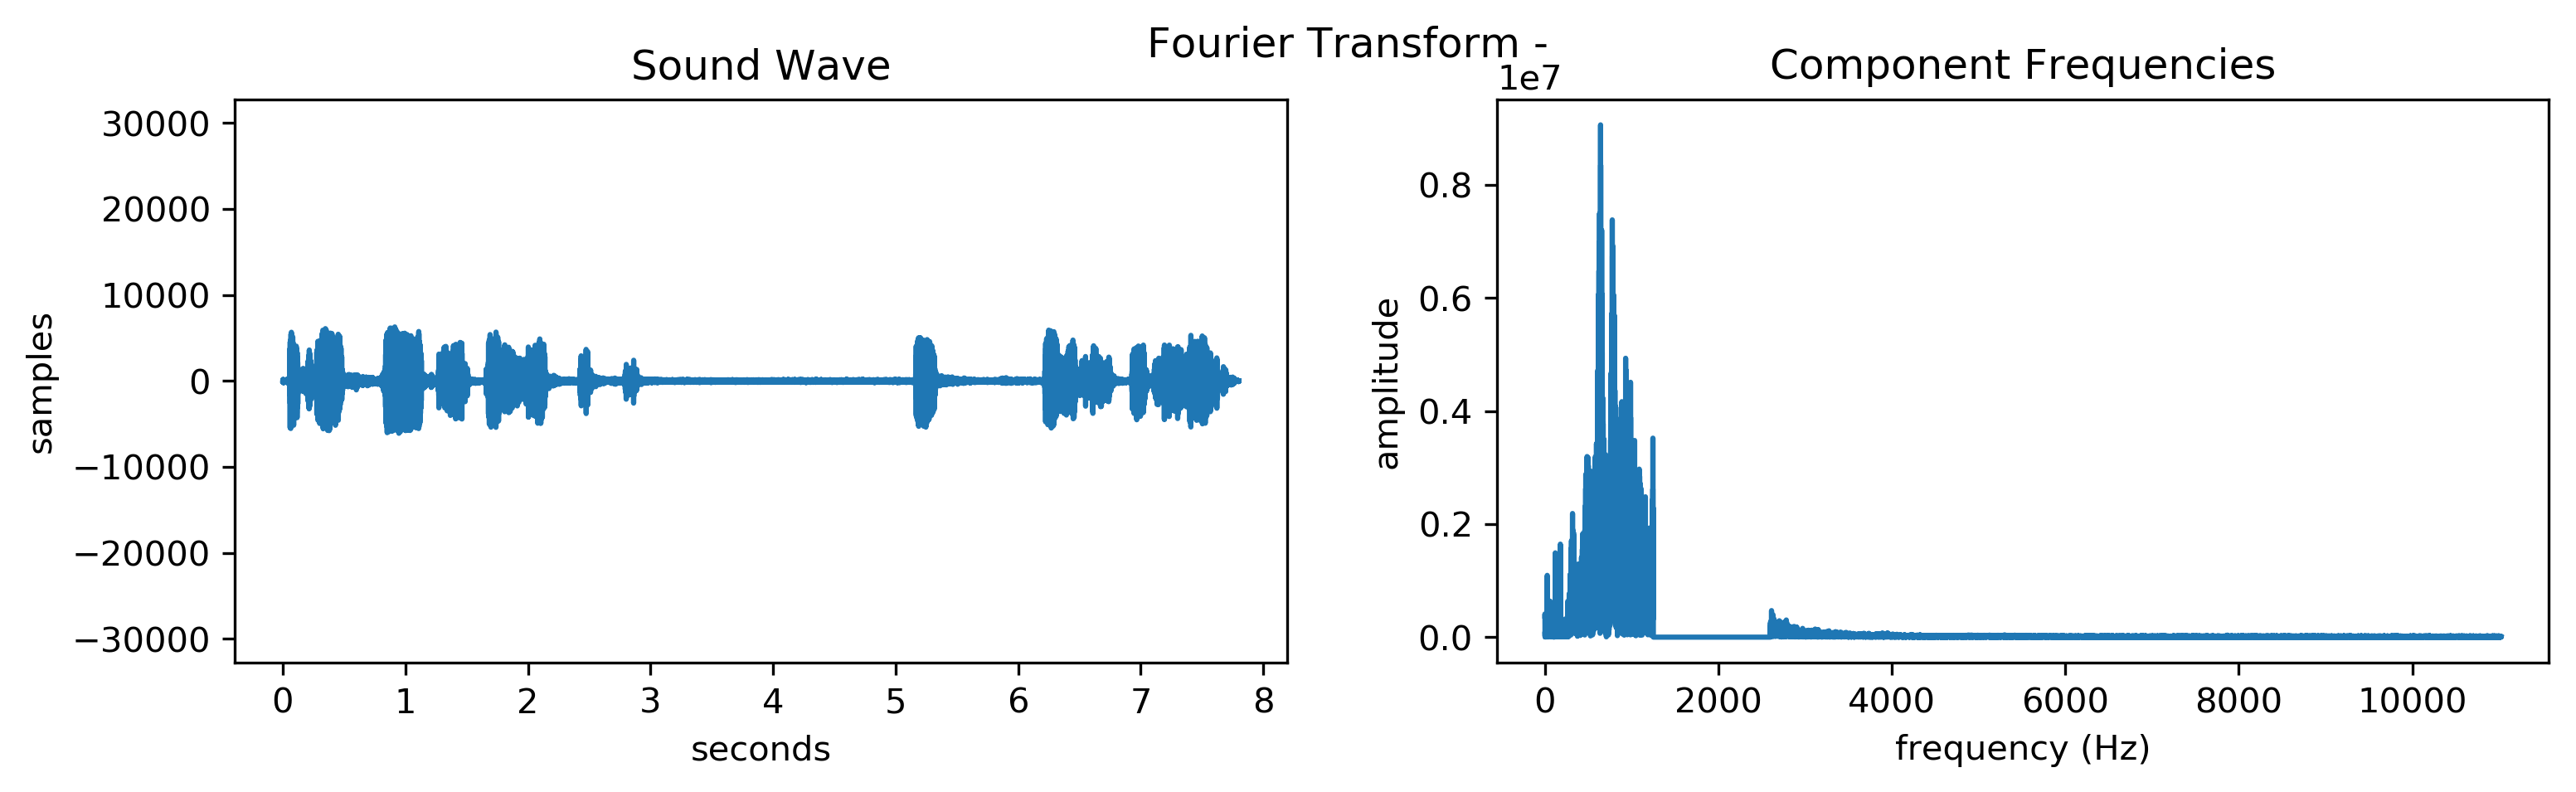

/anaconda3/lib/python3.6/site-packages/IPython/lib/display.py:124: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


In [19]:
# clean and plot noisy.wav
noisy.clean(1250,2600)
noisy.plot(dft=True)
noisy.play()

<h4 style="color: green">2.3.3 <code>noisy2.wav</code> RAW</h4>

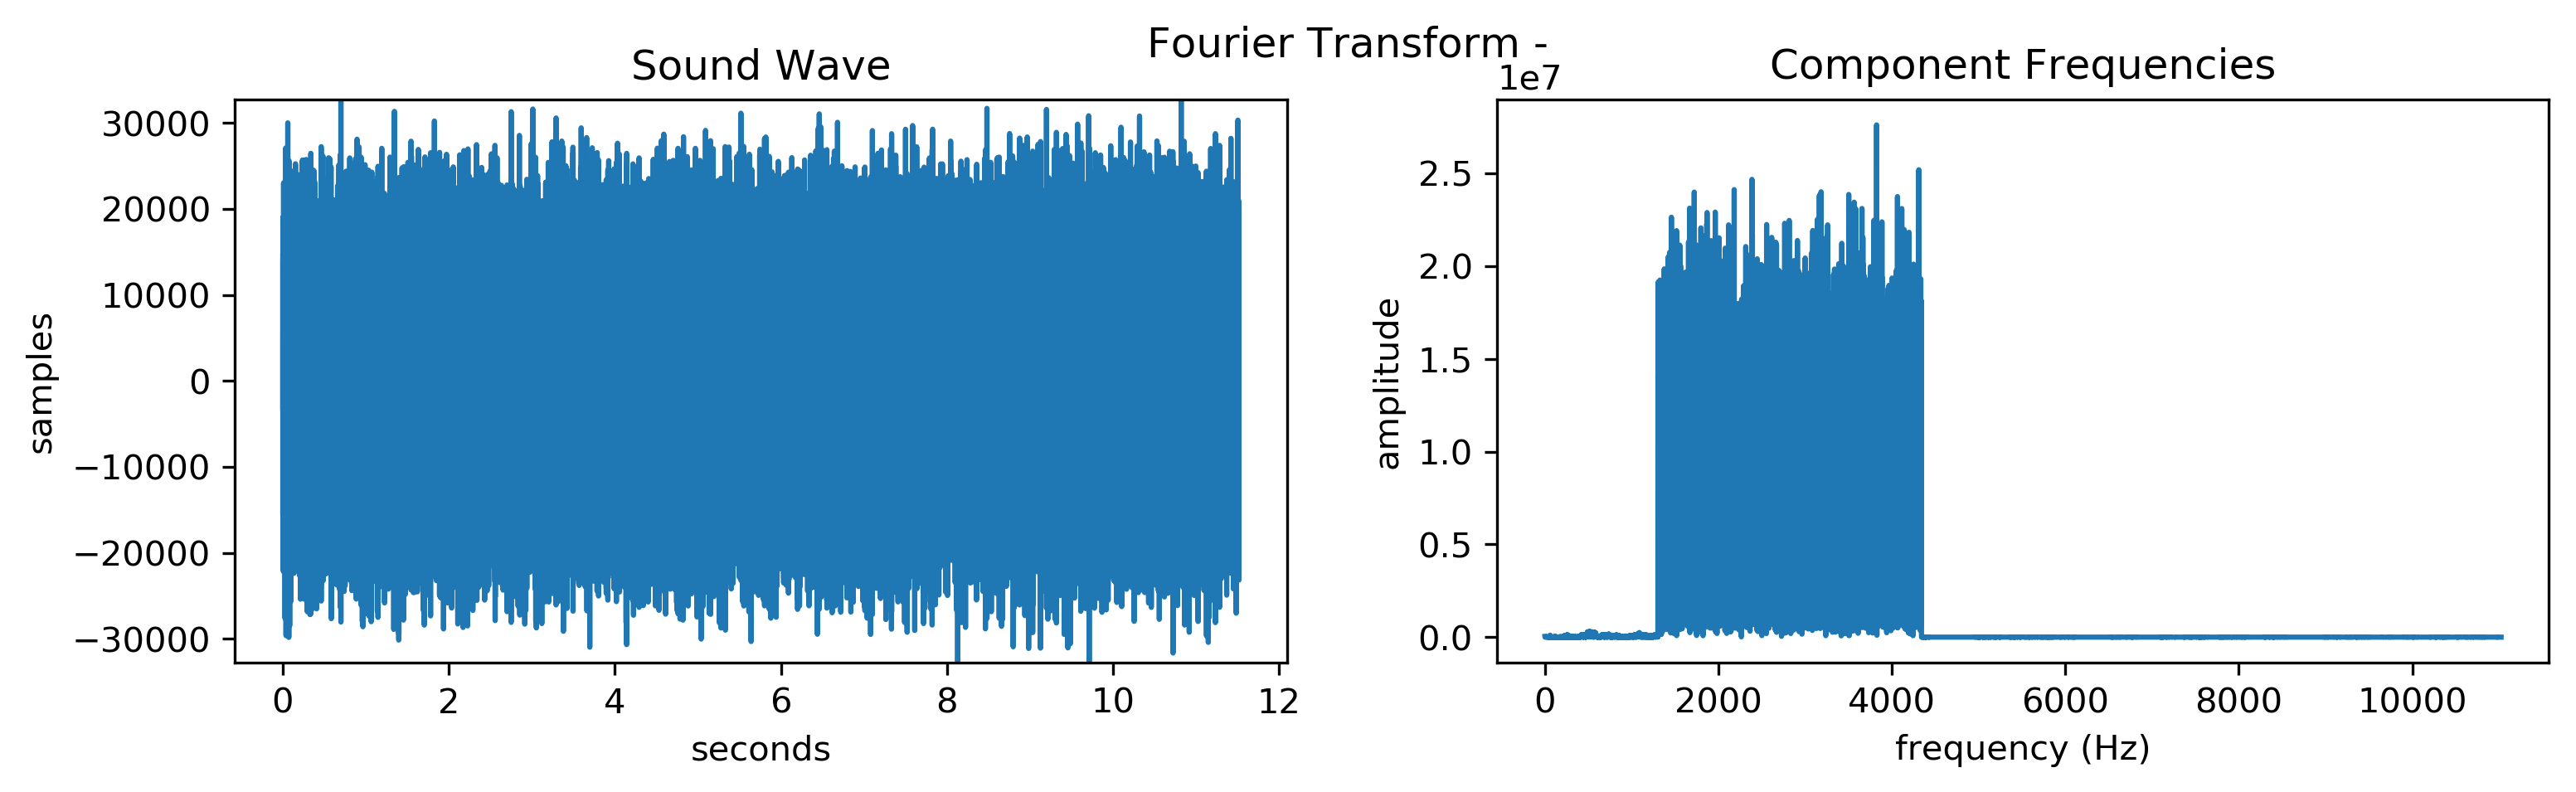

In [20]:
# get and plot noisy2.wav
noisy2 = SoundWave.with_file("noisy2.wav")
noisy2.plot(dft=True)
# noisy2.plot(dft=True)
noisy2.play()

<h4 style="color: green">2.3.4 <code>noisy2.wav</code> CLEAN</h4>

/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


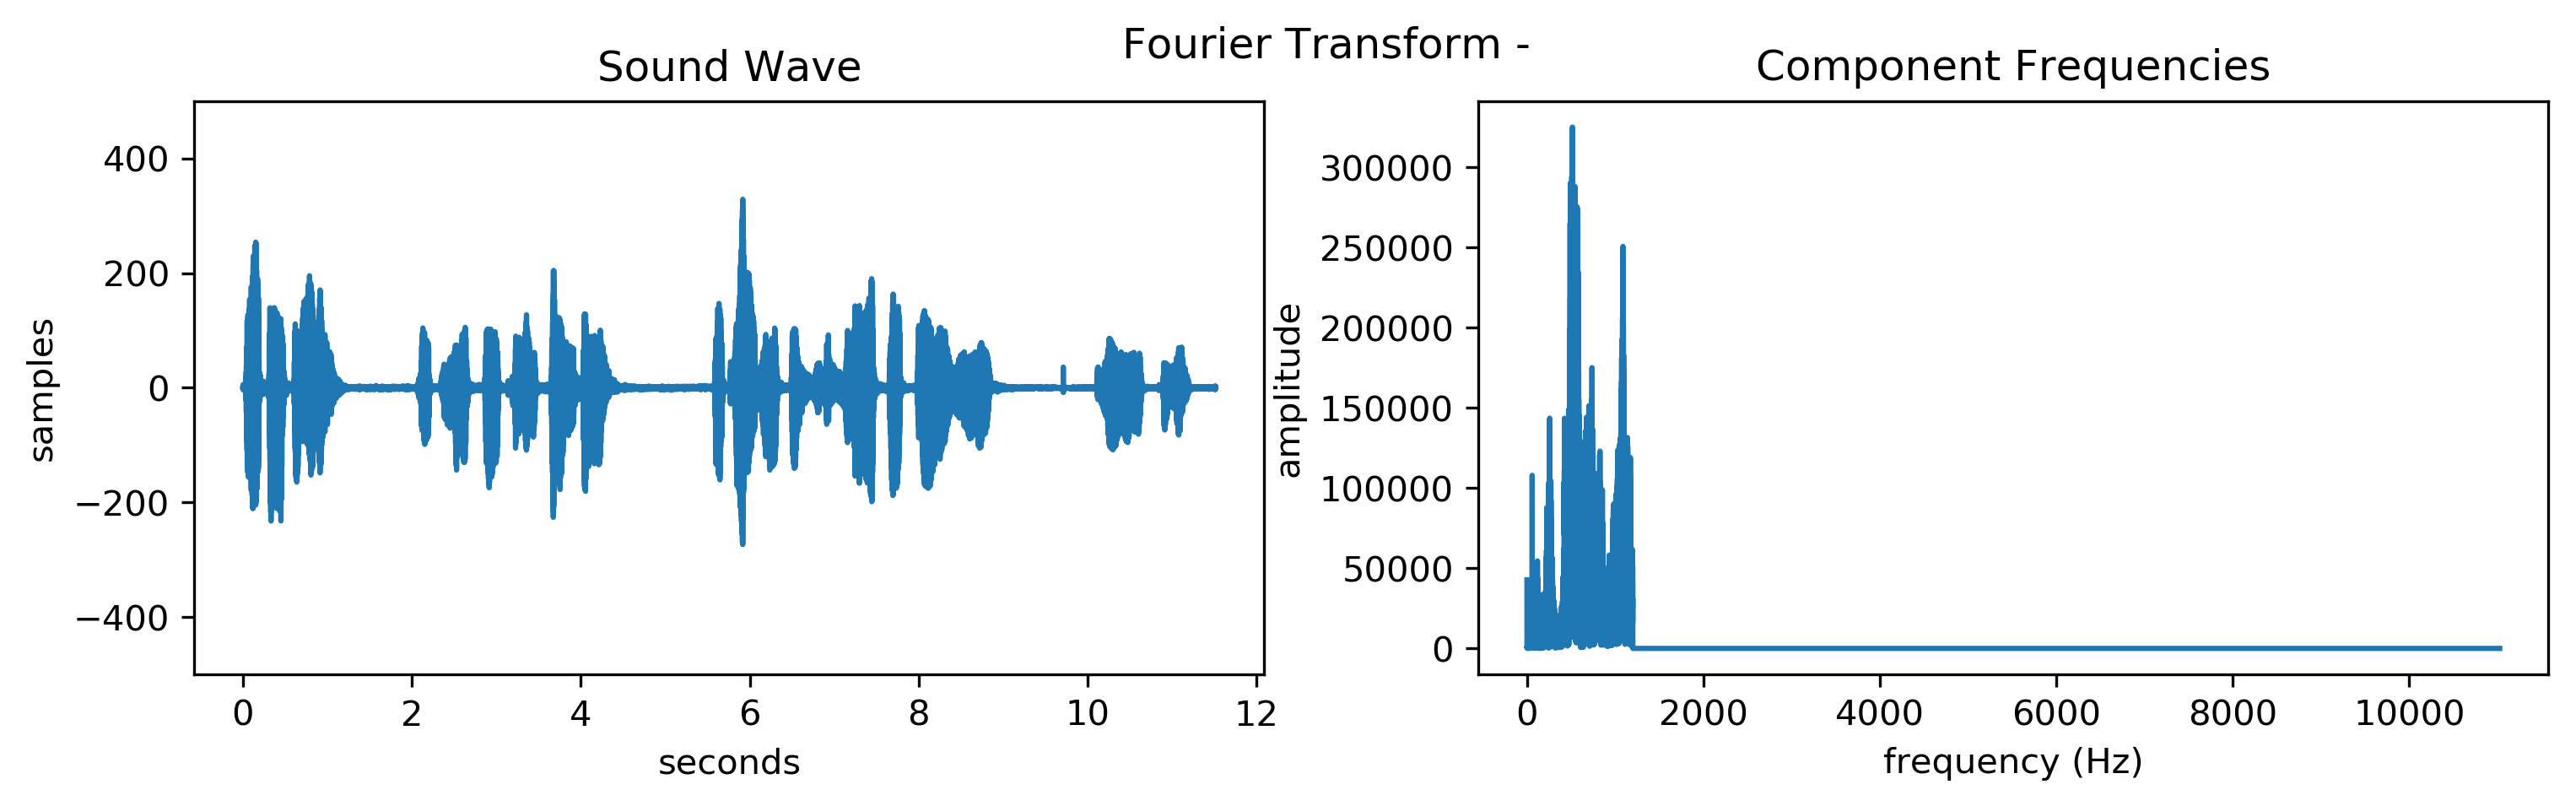

/anaconda3/lib/python3.6/site-packages/IPython/lib/display.py:124: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


In [21]:
# clean and plot noisy.wav
noisy2.clean(1200, 5000)
noisy2.clean(5000, 15000)
noisy2.plot(y_min=-500, y_max=500, dft=True)
# noisy2.plot(dft=True)
noisy2.play()

<h4 style="color: green">2.3.5 <code>vuvuzela.wav</code> RAW</h4>

In [22]:
# read and play original vuvuzela.wav
vuvu = SoundWave.with_file("vuvuzela.wav")
vuvu.play(stereo=True)

<h4 style="color: green">2.3.6 <code>vuvuzela.wav</code> CLEAN</h4>

In [23]:
# clean vuvuzela.wav
col1 = SoundWave(vuvu.rate, vuvu.samples[:, 0])
col2 = SoundWave(vuvu.rate, vuvu.samples[:, 1])
col1.clean(200,500)
col2.clean(200,500)
clean_vuvu = SoundWave(vuvu.rate, np.vstack([col1.samples, col2.samples]))
clean_vuvu.plot(dft+)
clean_vuvu.play()

SyntaxError: invalid syntax (<ipython-input-23-6965368edcc0>, line 7)

<h1 style="color: green;">2.4: Cleaning Images</h1>
<p></p>
</p> <code>license_plate.png</code> is a bad picture. <strong>We want to know the number on the sticker in the bottom right-hand corner.</strong></p>
<p>Images often have unwanted frequencies in them which cause distortion.</p> 
<p>For example,  pictures of a computer screen taken with a digital camera come out with weird lines.</p>

<p>
To correct it, we do the following:
<ol>
<li>Perform the 2-dimensional DFT on <code>license_plate.png</code> by performing the DFT on each row and then each column.</li>
<li>Replace the white spots (high frequencies) in the transformed image with the mean frequency.</li>
<li>Perform the inverse DFT on the edited transform to reveal the cleaned image.</li>
</ol>
</p>

<h4 style="color: green">2.4.1 <code>license_plate.png</code> Raw</h4>
<p>Observe all of the fuzzy lines.</p>

In [ ]:
im = imageio.imread('license_plate.png')
plt.imshow(im, cmap='gray')
plt.axis("off")
plt.show()

<h4 style="color: green">2.4.2 <code>license_plate.png</code> 2-dimensional DFT</h4>

In [ ]:
im_dft = fft2(im)
plt.imshow(np.log(np.abs(im_dft)), cmap='gray')
plt.axis("off")
plt.show()

<h4 style="color: green">2.4.3 <code>license_plate.png</code> Patched DFT</h4>

In [ ]:
# patch over a bunch of gray squares
mean = np.mean(im_dft)
im_dft[25:45, 90:110] = im_dft[100:120, :20]
im_dft[171:190, 320:345] = im_dft[100:119, :25]
im_dft[64:76, 196:208] = im_dft[100:112, :12]
im_dft[140:152, 226:240] = im_dft[100:112, :14]
im_dft[106:116, 124:136] = im_dft[100:110, :12]
im_dft[98:112, 295:315] = im_dft[100:114, :20]

# show patched DFT
plt.imshow(np.log(np.abs(im_dft.real)), cmap="gray")
plt.show()

<h4 style="color: green">2.4.4 <code>license_plate.png</code> Corrected Image</h4>

In [ ]:
# show corrected image
im_idft = ifft2(im_dft)
plt.imshow(im_idft.real, cmap="gray")
plt.show()

The year on the sticker is... 13!

<h2>And that concludes this showcase of my implementation of the Fourier transform and a few of its relevant applications. I hope you enjoyed it!<h2>